# Fig 1. Supplementary materials 

1. nAHD from all obs datasets for WBGT28
2. nAHD from all GCMs for WBGT28
3. horizontal latitude plots for all 

To finalize
- make sure i am using same present day year for all datasets : decide how to model covariates (do you used smooth or unsmoothed? and -GWI)
- make prettier
- potentially can include CI for nAHD and p0 but I think it gets messy... maybe not necessary

Extra stuff for SI
- all 3 obs datasets (SI)
- all models (SI) -> move out of here !
- maps + histograms


To do elsewhere: 
- eval model v. obs doing shift fit in both
- eval/stability of different time periods for shift fit in obs (?) or goodness of fit in another way - ask Clair

In [1]:
# necessary:  netcdf4-python, regionmask (automatically imports xarray), Cartopy, openpyxl,( statsmodels - do i need this ?)

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
%matplotlib inline

#import os, glob, re 
#import math
import xarray as xr
import geopandas as gpd
import regionmask as regionmask
#import dask
#import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4
#import rasterio
#from rasterio.features import geometry_mask
from scipy.stats import norm



In [2]:
from settings_ana import *
from functions_ana import * 
from plotscript import *

# sys.path.append(os.path.join('.','dem4cli/')) #
# from population_demographics import * 

In [3]:
start_message()

flags: {'models': 'ISIMIP3b', 'experiment': None, 'metric': 'WBGT28', 'method': None, 'time_method': None, 'shift_sigma': False, 'shift_period': None, 'shift_loglike': None, 'chunk_version': None, 'var': 'wbgt'}
var: wbgt
VARs: None
indir_p: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/InputData/climate/atmosphere/bias-adjusted/global/daily/
indir_s: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/
indir_obs: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/obsclim/global/daily/historical/
indir_counterclim: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/counterclim/global/daily/historical/
GCMs: ['CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0', 'EC-Earth3', 'UKESM1-0-LL', 'MPI-ESM1-2-HR', 'CNRM-ESM2-1']
datasets: ['GSWP3-W5E5', '20CRv3-ERA5', '20CRv3-W5E5']
lat_chunk: 90
lon_chunk: 120
tim

In [4]:
# SETTINGS
figdir = os.path.join(figdirs, 'fig_sep24')

# plot settings
matplotlib.rc('axes',edgecolor='k')
fg_color = 'k' 

# geo information
landmask = get_mask()
cellarea = xr.open_dataarray(os.path.join(datadirs,'geo-information/clm45_area.nc4'))

## Fxns : put this elsewhere! and check/finalise covariate/gwi I am using

In [5]:
def calc_nAHD_shift_fit(da_params, threshold, gmst_smo,year_pres=2022,GWI=1.3):

    gmst_pres = float(gmst_smo.loc[year_pres]) # take smoothed or not smoothed covariate ?? 
    gmst_pi = float(gmst_pres - GWI)

    b0 = da_params.sel(params='b0')
    b1 = da_params.sel(params='b1')


    if len(da_params.params) >3:
        sigma_b0 = da_params.sel(params='sigma_b0')
        sigma_b1 = da_params.sel(params='sigma_b1')
        norm_pi, norm_pres = norm(loc=b0+b1*gmst_pi, scale=sigma_b0+sigma_b1*gmst_pi), norm(loc=b0+b1*gmst_pres, scale=sigma_b0+sigma_b1*gmst_pres)
    elif len(da_params.params) ==3:
        sigma_b0 = da_params.sel(params='sigma')
        norm_pi, norm_pres = norm(loc=b0+b1*gmst_pi, scale=sigma_b0), norm(loc=b0+b1*gmst_pres, scale=sigma_b0)

    data = norm_pres.sf(threshold)
    da_p1 = xr.DataArray(
        data=data,
        dims=["dataset", "month", "lat", "lon", ],
        coords=dict(
            lon=(["lon"], da_params.lon.data),
            lat=(["lat"], da_params.lat.data),
            month=da_params.month.data,
            dataset=da_params.dataset.data) )
    
    data = norm_pi.sf(threshold)
    da_p0 = xr.DataArray(
        data=data,
        dims=[ "dataset", "month", "lat", "lon"],
        coords=dict(
            lon=(["lon"], da_params.lon.data),
            lat=(["lat"], da_params.lat.data),
            month=da_params.month.data,
            dataset=da_params.dataset.data) )

    days_in_month = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]) # ignoring leap years

    # add dimension for correct multiplication
    days_in_month_da = xr.DataArray(days_in_month, dims=['month'], coords={'month': da_p1['month']})

    # calc nAHD per month and per year
    da_nAHD_mo = (da_p1 - da_p0) * days_in_month_da
    
    da_nAHD = da_nAHD_mo.sum(dim='month')


    return da_nAHD, da_nAHD_mo, da_p0, da_p1

In [6]:
def plot_barplot_mean_lat(da_p1_lat, 
                          da_nAHD_lat,
                          ax,
                          isel_cols = None,
                          title = ' \n \n',
                          plot_ylabels=True,
                          bar_width = 0.1,
                          second_legend=True,
                          legend_anchor = (1, 1.15),
                          xlabel='Days per year'
                          ): # could also do lat processing in here ! 
    
    df_nAHD = da_nAHD_lat.to_pandas().T # or move this out of the fxn !! 
    df_p1 = da_p1_lat.to_pandas().T 

    if isel_cols: # maybe delete this ?? 
        df_nAHD = df_nAHD.iloc[:,[isel_cols]]
        df_p1 = df_p1.iloc[:,[isel_cols]]
    
    # Settings
    bar_width = bar_width
    index = df_nAHD.index.astype(str)
    index = [s.replace('(', '').replace(']', '').replace(',', '°,') + '°' for s in index]
    cmap = matplotlib.colormaps['tab10'] #plt.cm.get_cmap('tab10')
    colors = [cmap(i) for i in np.linspace(0, 1, 10)]
    columns = df_nAHD.columns

    # Plot each model side by side
    for i, column in enumerate(columns):
        ax.barh(np.arange(0, len(index)) - (i-len(columns)//2) * bar_width, df_nAHD[column], bar_width, label=column,color=colors[i])
        ax.barh(np.arange(0,len(index)) - (i-len(columns)//2) * bar_width, df_p1[column], bar_width,  color=colors[i],alpha=0.4) 
    ax.set_ylim(0,7.6)

        
    # Set labels and title
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    if plot_ylabels:
        ax.set_yticks(np.arange(0, len(index)))  # Set the y-tick positions
        ax.set_yticklabels(index, rotation=0)
    else:
        ax.set_yticks(np.arange(0, len(index))) 
        ax.set_yticklabels([])

    
    lgd = ax.legend(fontsize=9,frameon=False, loc='upper right',handlelength=1.2,handletextpad=0.4,bbox_to_anchor=legend_anchor)
    if second_legend:
        tot_patch = mpatches.Patch(color=colors[0], label='days$_{tot}$',alpha=0.4,edgecolor=None)
        attr_patch = mpatches.Patch(color=colors[0], label='days$_{attr}$')
        ax.legend(handles = [tot_patch, attr_patch ], fontsize=9,frameon=False, loc='lower right',
                  handlelength=1.2,handletextpad=0.4,labelspacing = .1) 
        ax.add_artist(lgd)
        
    # Hide spines 
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)





In [7]:
def plot_map_nAHD(data_plot,
                    ax,
                    proj=ccrs.PlateCarree(),
                    vmin = -100,
                    vmax = 200, 
                    levels = np.linspace(-100, 200, 16),
                    title_label = None,
                  title=True
            ):

    cmap = LinearSegmentedColormap.from_list('new_RdBu_r', plt.get_cmap('RdBu_r')(np.linspace(0.25, 1, 192))) 
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    crs = ccrs.PlateCarree()
    ax.set_extent([-179.75, 179.75, -60, 90], crs=ccrs.PlateCarree())

    # plot
    plot = data_plot.plot(vmin=vmin, vmax=vmax, cmap=cmap, transform=crs, levels=levels, extend='both', add_colorbar=False, ax=ax)
    ax.coastlines(color='black', linewidth=0.8)
    if title:
        try: 
            ax.set_title(f'{data_plot.dataset.values}')
        except:
            ax.set_title(f'{data_plot.model.values}')
    else:
        ax.set_title('')
            
    ax.set_title(title_label, loc='left',fontweight='bold')

    return plot 



## 1a. nAHD (WBGT28) in obs

To do:
- for paper do it only with one of the obs? add the horizontal hist and make a single figure together with demographics fig, put the other obs in SI
- fix colorbar limits
- do some regional/focus area analysis, worst hit areas etc.
- check covariate value for present and GWI value (GHG=1.45 or anthro=1.29?) - or real time online 1.304 (i think this is anthro)

Notes:
- very similar to ATTRICI obsclim v. counterclim (see isimip3a-wbgt-obsclim-counterclim), same patterns but larger numbers here, bc ref periods are also shifted, probably

In [8]:
# open data
flags['models']='ISIMIP3a'
dirname = 'output_shift-fit' 
startyear=1950
da_list = []

for i in range(len(datasets)):
    dataset = datasets[i]
    filepath = glob.glob(os.path.join(outdirs, 
                                      f'output_shift-fit/forster2024/WBGT/ISIMIP3a/{dataset}/*_obsclim_WBGT_params_shift_loc_mon_loglike_{str(startyear)}_2019.nc'))[0]
    da = xr.open_dataarray(filepath).expand_dims("dataset").assign_coords(dataset=("dataset", [dataset]))
    da_list.append(da)
    da_params = xr.concat(da_list, dim="dataset")
    

In [9]:
df_gmst_obs_annual = pd.read_csv(os.path.join(datadirs,'gmst/gmst-obs/forster2024/annual_averages.csv')).rename(
    columns={'timebound_lower':'year'}).set_index('year')[['gmst']]
gmst_smo = pd.DataFrame(apply_lowess(df_gmst_obs_annual, df_gmst_obs_annual.index, ntime=4))
gmst_smo

,gmst
year,
1850,-0.050939
1851,0.034209
1852,0.071770
1853,0.067307
1854,0.058773
...,...
2019,1.210821
2020,1.209226
2021,1.160743


In [10]:
from scipy.stats import norm

threshold = 28

da_nAHD_obs, da_nAHD_mo, da_p0, da_p1 = calc_nAHD_shift_fit(da_params, threshold, gmst_smo,year_pres=2023,GWI=1.3)

/tmp/ipykernel_1217593/927337717.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  gmst_pres = float(gmst_smo.loc[year_pres]) # take smoothed or not smoothed covariate ??


## Horizontal latitudinal area-weighted average bar plot : obs

Notes:
- obs generally agree on nAHD but don't agree on total n of days crossing threshold today? w5e5 is much more. But why is nAHD so similar then? And dont agree on baseline n of days crossing in pre-industrial
  
To define/finalize:
- giving each month equal weight (also in calc nAHD) - correct and use month length as weight? also use 30.4 
 
Extra:
+ add cities inset where super high (somewhere in India, somewhere in Indonesia, somewhere in S.America / Africa... Or in SI / conceptual figure ! with threshold and p1/p0 etc
+ make this lat bar fig also for models? 

In [11]:
# Define the latitudinal bands
lat_bins = range(-90, 91, 20)
[i for i in lat_bins]

[-90, -70, -50, -30, -10, 10, 30, 50, 70, 90]

In [12]:
weighted_sum = (da_p1 * landmask * 30.4 * cellarea).groupby_bins('lat', lat_bins[1:]).sum(dim=['lat','lon','month']) 
total_area = (cellarea * landmask).groupby_bins('lat', lat_bins[1:]).sum(dim=['lat','lon'])

da_p1_mean_lat = weighted_sum / total_area 
#da_p1_mean_lat.to_pandas().T

In [23]:
weighted_sum = (da_nAHD_obs * landmask * cellarea).groupby_bins('lat', lat_bins[1:]).sum(dim=['lat','lon']) 
total_area = (cellarea * landmask).groupby_bins('lat', lat_bins[1:]).sum(dim=['lat','lon'])

da_nAHD_mean_lat = weighted_sum / total_area 
da_nAHD_mean_lat.to_pandas().T.round(2)

dataset,GSWP3-W5E5,20CRv3-ERA5,20CRv3-W5E5
lat_bins,,,
"(-70, -50]",0.00,0.00,0.00
"(-50, -30]",1.23,1.48,2.01
"(-30, -10]",19.49,14.25,14.41
"(-10, 10]",62.32,63.64,72.62
"(10, 30]",37.93,31.99,28.37
"(30, 50]",4.79,2.70,2.79
"(50, 70]",0.18,0.08,0.08
"(70, 90]",0.01,0.00,0.00


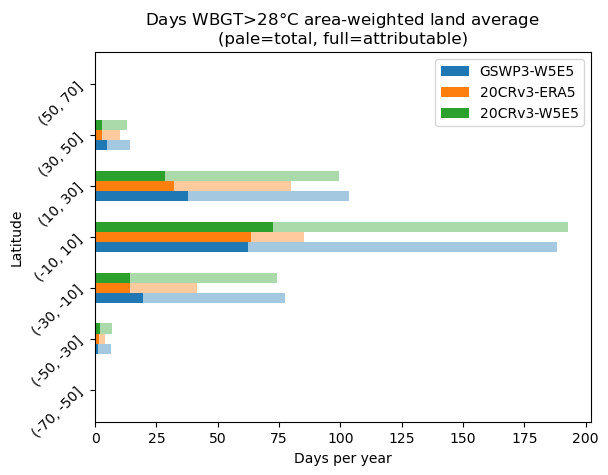

In [14]:
# set hatch color 
plt.rcParams["hatch.color"] = 'gray'

# Convert xarray DataArray to a pandas DataFrame and get rid of 70-90N
df_nAHD = da_nAHD_mean_lat.to_pandas().T.iloc[:-1,:]
df_p1 = da_p1_mean_lat.to_pandas().T.iloc[:-1,:]

# Get the list of column names
columns = df_p1.columns

# Set up the figure and axis
fig, ax = plt.subplots()

# Define width for each bar
bar_width = 0.2

# Define the index values for x-axis
index = df_p1.index.astype(str)

cmap = matplotlib.colormaps['tab10'] #plt.cm.get_cmap('tab10')
colors = [cmap(i) for i in np.linspace(0, 1, 10)]

# Plot each column side by side
for i, column in enumerate(columns):
    ax.barh(np.arange(0,len(index)) + (i-1) * bar_width, df_p1[column], bar_width,  color=colors[i],alpha=0.4) #label=column,
    ax.barh(np.arange(0,len(index)) + (i-1) * bar_width, df_nAHD[column], bar_width, label=column,color=colors[i])

    
# Set labels and title
ax.set_ylabel('Latitude')
ax.set_xlabel('Days per year')
ax.set_title('Days WBGT>28$\degree$C area-weighted land average \n(pale=total, full=attributable)')
plt.yticks(ticks=np.arange(0,len(index)), labels=index, rotation=45)
ax.legend()

# Show plot
plt.show()

## Combine 

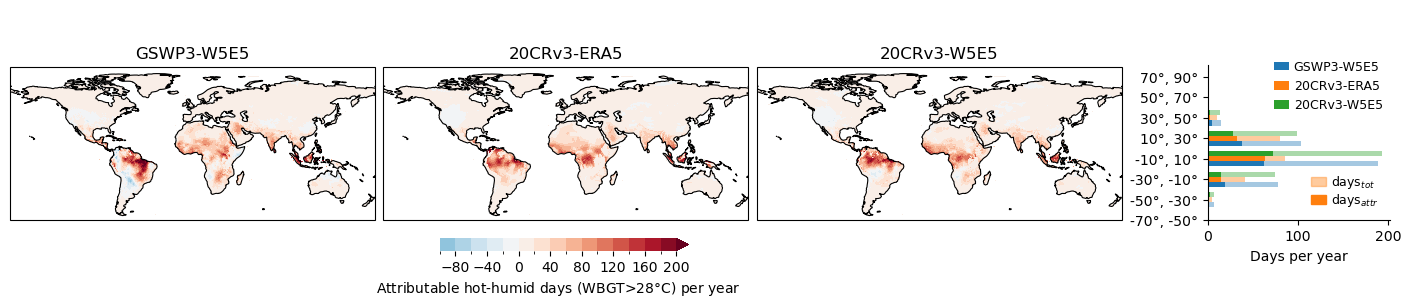

In [15]:

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches


# settings 
proj = ccrs.PlateCarree() #ccrs.Robinson()
crs = ccrs.PlateCarree()

# cmap
cmap = plt.get_cmap('RdBu_r')
cmap_data = cmap(np.linspace(0, 1, 256))
new_cmap_data = cmap_data[64:]  # This excludes the first quarter (64/256)
new_cmap = LinearSegmentedColormap.from_list('new_RdBu_r', new_cmap_data)

# Define the normalization boundaries
vmin, vmax = -100, 200
levels = np.linspace(vmin, vmax, 16)
norm = BoundaryNorm(levels, ncolors=new_cmap.N, clip=True)




# create figure layout
fig = plt.figure(figsize=(14, 3), layout='constrained')  
gs = gridspec.GridSpec(1, 4, width_ratios=[2,2,2,1],figure=fig)  

# plot observational nAHD 
axes = [0,0,0,0]
for i in range(3):
    data_plot = da_nAHD_obs.isel(dataset=i) * landmask  # include or not landmask ?? 
    axes[i]= fig.add_subplot(gs[0, i], projection= proj)  
    ax=axes[i]
    ax.set_extent([-181, 181, -60, 90], crs=ccrs.PlateCarree())
    plot = data_plot.plot(vmax=vmax, vmin=vmin, cmap=new_cmap,  transform=crs, levels=levels, extend='both', add_colorbar=False, ax=ax) #norm=norm,
    ax.coastlines(color='black', linewidth=0.8)
    ax.set_title(f'{data_plot.dataset.values}', color=fg_color)
    #ax.gridlines(draw_labels=False)


# colorbar 
cbar_lab = 'Attributable hot-humid days (WBGT>28$\degree$C) per year'
cbar = fig.colorbar(plot, extend='max', ax=axes[0:3], location='bottom',shrink=0.3, fraction=0.08, pad=-0.15)
cbar.set_label(label=cbar_lab, color=fg_color)
cbar.ax.xaxis.set_tick_params(which='both', color=fg_color, labelcolor=fg_color)
cbar.outline.set_edgecolor('none')



ax= fig.add_subplot(gs[0, 3])  

# Convert xarray DataArray to a pandas DataFrame 
df_nAHD = da_nAHD_mean_lat.to_pandas().T#.iloc
df_p1 = da_p1_mean_lat.to_pandas().T#.iloc
# Settings
bar_width = 0.25
index = df_p1.index.astype(str)
index = [s.replace('(', '').replace(']', '').replace(',', '°,') + '°' for s in index]
columns = df_p1.columns
cmap = matplotlib.colormaps['tab10'] #plt.cm.get_cmap('tab10')
colors = [cmap(i) for i in np.linspace(0, 1, 10)]
# Plot each column side by side
for i, column in enumerate(columns):
    ax.barh(np.arange(0,len(index)) + (i-1) * bar_width, df_nAHD[column], bar_width, label=column,color=colors[i])
    ax.barh(np.arange(0,len(index)) + (i-1) * bar_width, df_p1[column], bar_width,  color=colors[i],alpha=0.4) 
ax.set_ylim(0,7.6) # match latitudes

    
# Set labels and title
ax.set_xlabel('Days per year')
ax.set_title(' \n \n')
plt.yticks(ticks=np.arange(0,len(index)), labels=index, rotation=0)
# add two legends
lgd = ax.legend(fontsize=9,frameon=False, loc='upper right',handlelength=1.2,handletextpad=0.4,bbox_to_anchor=(1.02, 1.1))
tot_patch = mpatches.Patch(color=colors[1], label='days$_{tot}$',alpha=0.4,edgecolor=None)
attr_patch = mpatches.Patch(color=colors[1], label='days$_{attr}$')
ax.legend(handles = [tot_patch, attr_patch ], fontsize=9,frameon=False, loc='lower right',handlelength=1.2,handletextpad=0.4,labelspacing = .1) 
ax.add_artist(lgd)
# Hide spines 
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)


In [16]:
print('min, max, mean (over land, not area-weighted)')

for i in range(3):
    data = da_nAHD_obs.isel(dataset=i) * landmask 
    print(data.dataset.values, data.min().values, data.max().values, data.mean().values)


min, max, mean (over land, not area-weighted)
GSWP3-W5E5 -89.72539626411351 272.25418717690917 15.377862360682855
20CRv3-ERA5 -16.56611762151402 283.43126361971156 13.690710093940245
20CRv3-W5E5 -33.574078685604555 227.3993519052058 14.20174307986856


## Climate models 

Todo:
- in SI plot with each model
- keep this cbar? so i have only one cbar for obs and models?

Extra
- plot diff nahd models-obs make a new eval figure/plot

In [17]:
dirname='output_empirical'
models='ISIMIP3b'

year=2023

da_nAHD_models = open_all_nAHD(GCMs,  metric='WBGT28', outdirname=dirname, year_pres=year) # see here i coded what models it is in the fxn 
empty, da_p1_models = open_all_p0_p1(GCMs, metric='WBGT28', outdirname=dirname, year_pres=year)

In [18]:
weighted_sum = (da_nAHD_models * landmask * cellarea).groupby_bins('lat', lat_bins[1:]).sum(dim=['lat','lon']) 
total_area = (cellarea * landmask).groupby_bins('lat', lat_bins[1:]).sum(dim=['lat','lon'])

da_nAHD_mean_lat_models = weighted_sum / total_area 
#da_nAHD_mean_lat_models.to_pandas().T

In [19]:
weighted_sum = (da_p1_models * 365 * landmask * cellarea).groupby_bins('lat', lat_bins[1:]).sum(dim=['lat','lon']) 
total_area = (cellarea * landmask).groupby_bins('lat', lat_bins[1:]).sum(dim=['lat','lon'])

da_p1_mean_lat_models = weighted_sum / total_area 
#da_p1_mean_lat_models.to_pandas().T

## Plot 

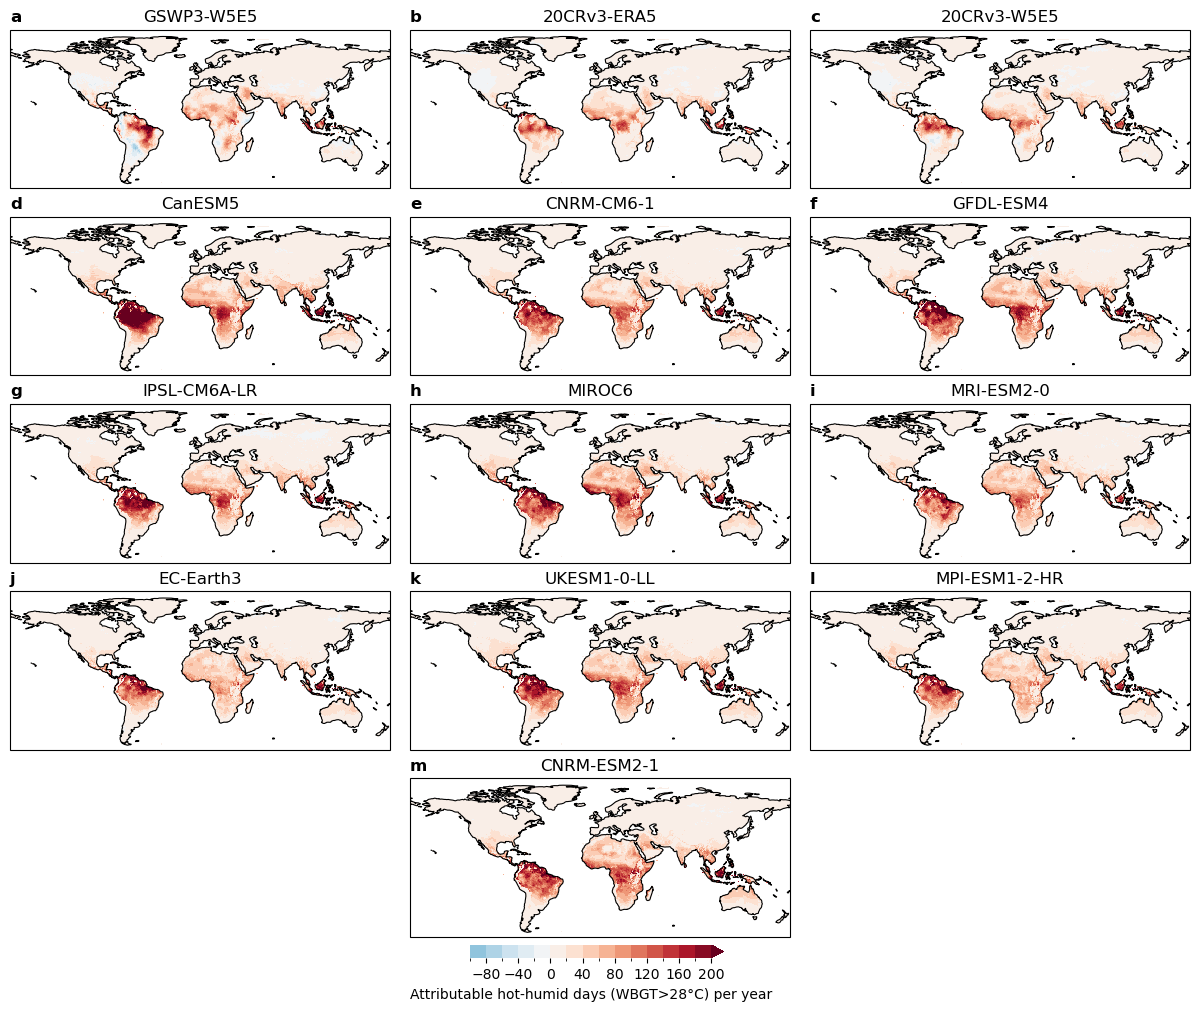

In [20]:
import string

# Settings
proj = crs = ccrs.PlateCarree()
cmap = LinearSegmentedColormap.from_list('new_RdBu_r', plt.get_cmap('RdBu_r')(np.linspace(0.25, 1, 192))) 
vmin, vmax, levels = -100, 200, np.linspace(-100, 200, 16)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
titles = [f"{letter}" for letter in string.ascii_lowercase[:13]]

# Create figure layout
fig = plt.figure(figsize=(12,10), layout='constrained')
gs = gridspec.GridSpec(5, 6, figure=fig)

# Plot observed data
for j in range(3):
    ax = fig.add_subplot(gs[0, j*2:j*2+2], projection=proj)
    data_plot = da_nAHD_obs.isel(dataset=j) * landmask
    plot_map_nAHD(data_plot,
                  ax,
                  title_label=titles[j],)

# Plot model data
for i in range(1, 5):
    for j in range(3):
        if (i-1)*3 + j > 8: break
        ax = fig.add_subplot(gs[i, j*2:j*2+2], projection=proj)
        data_plot = da_nAHD_models.isel(model=(i-1)*3+j) * landmask
        plot_map_nAHD(data_plot,
                  ax,
                  title_label=titles[3 + (i-1)*3 + j],)

# Extra model subplot
ax = fig.add_subplot(gs[4, 2:4], projection=proj)
data_plot = da_nAHD_models.isel(model=9) * landmask
plot_map_nAHD(data_plot,
                  ax,
                  title_label=titles[-1],)

# Colorbar
cbar = fig.colorbar(plot, extend='max', ax=ax, location='bottom', shrink=1, fraction=0.08)
cbar.set_label('Attributable hot-humid days (WBGT>28°C) per year', )
cbar.outline.set_edgecolor('none')


plt.savefig(os.path.join(figdir,'fig1_SI_maps.pdf'),dpi=300,transparent=True)
plt.savefig(os.path.join(figdir,'fig1_SI_maps.png'),dpi=300,transparent=True)


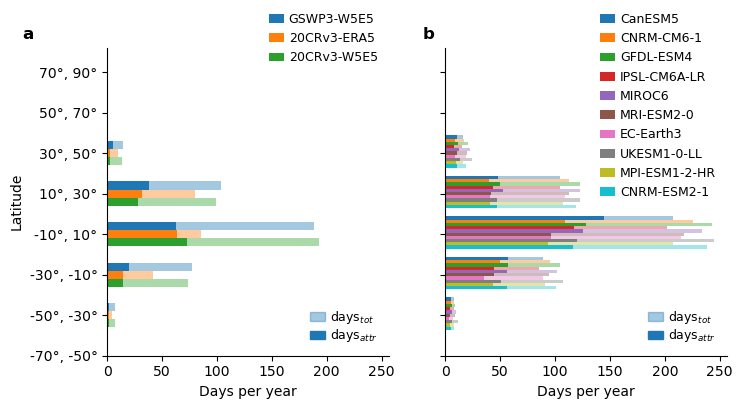

In [21]:

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4)) # try 7,3 for smaller

# Bar plot obs
plot_barplot_mean_lat(da_p1_mean_lat, 
                          da_nAHD_mean_lat,
                          ax=ax1,
                          second_legend=True,
                            plot_ylabels=True,
                          bar_width = 0.2,
                      title='\n',
                      #xlabel='Hot-humid days (WBGT>28°C) per year'
                     )
ax1.set_title('a',loc='left',fontweight='bold',x=-.3)
ax1.set_ylabel('Latitude')

# Bar plot models 
ax2.sharex(ax1)
plot_barplot_mean_lat(da_p1_mean_lat_models, 
                          da_nAHD_mean_lat_models,
                          ax=ax2,
                         plot_ylabels=False,
                         bar_width = 0.08,
                     title='\n',)
ax2.set_title('b',loc='left',fontweight='bold',x=-.08);


plt.savefig(os.path.join(figdir,'fig1_SI_barplot.pdf'),dpi=300,transparent=True)
plt.savefig(os.path.join(figdir,'fig1_SI_barplot.png'),dpi=300,transparent=True)


In [27]:
da_nAHD_mean_lat.to_pandas().T.round(2)

dataset,GSWP3-W5E5,20CRv3-ERA5,20CRv3-W5E5
lat_bins,,,
"(-70, -50]",0.00,0.00,0.00
"(-50, -30]",1.23,1.48,2.01
"(-30, -10]",19.49,14.25,14.41
"(-10, 10]",62.32,63.64,72.62
"(10, 30]",37.93,31.99,28.37
"(30, 50]",4.79,2.70,2.79
"(50, 70]",0.18,0.08,0.08
"(70, 90]",0.01,0.00,0.00


In [28]:
da_p1_mean_lat.to_pandas().T.round(2)

dataset,GSWP3-W5E5,20CRv3-ERA5,20CRv3-W5E5
lat_bins,,,
"(-70, -50]",0.00,0.00,0.00
"(-50, -30]",6.60,4.17,6.86
"(-30, -10]",77.54,41.40,74.02
"(-10, 10]",188.47,85.34,192.61
"(10, 30]",103.49,79.99,99.28
"(30, 50]",14.03,10.06,13.00
"(50, 70]",0.28,0.20,0.22
"(70, 90]",0.02,0.00,0.01
